In [1]:
%matplotlib inline

In [2]:
import numpy as np
from io import StringIO
from astropy.constants import c
import matplotlib.pyplot as plt
import itertools
from astropy.coordinates import Angle
from astropy import units as u
from astropy.coordinates import EarthLocation, AltAz, ITRS, CartesianRepresentation, UnknownSiteException

In [3]:
def calc_R(H,dec):
    if np.isscalar(H):
        H = np.array([H])

    R = np.array([[np.sin(H), np.cos(H), np.zeros_like(H)],\
        [-np.sin(dec)*np.cos(H), np.sin(dec)*np.sin(H), np.cos(dec) * np.ones_like(H)],\
        [np.cos(dec)*np.cos(H), -np.cos(dec)*np.sin(H), np.sin(dec) * np.ones_like(H)]])

    return R

In [4]:
def _altaz_to_earthlocation(altaz):
    local_itrs = altaz.transform_to(ITRS(location=altaz.location))
    itrs = ITRS(local_itrs.cartesian + altaz.location.get_itrs().cartesian)
    return itrs.earth_location

In [5]:
def _earthlocation_to_altaz(location, reference_location):
    # See
    # https://docs.astropy.org/en/stable/coordinates/common_errors.html#altaz-calculations-for-earth-based-objects
    # for why this is necessary and we cannot just do
    # `get_itrs().transform_to(AltAz())`
    itrs_cart = location.get_itrs().cartesian
    itrs_ref_cart = reference_location.get_itrs().cartesian
    local_itrs = ITRS(itrs_cart - itrs_ref_cart, location=reference_location)
    return local_itrs.transform_to(AltAz(location=reference_location))

In [6]:
def local_enu_to_earth_location(e, n, u, reference_location):
    down = -u
    cart = CartesianRepresentation(n, e, down)
    altaz = AltAz(cart, location=reference_location)
    return _altaz_to_earthlocation(altaz)

In [7]:
def earth_location_to_local_enu(location, reference_location):
    altaz = _earthlocation_to_altaz(location, reference_location)
    ned_coords =  altaz.cartesian.xyz
    enu_coords = ned_coords[1], ned_coords[0], -ned_coords[2]
    return enu_coords

In [8]:
def enu_to_local_altaz(enu_baselines, distance):
    azimuth = np.arctan2(enu_baselines[0], enu_baselines[1])
    elevation = np.arcsin(enu_baselines[2]/distance) 
    return azimuth, elevation

In [9]:
def read_txt_file(filename):
    # Read data
    dtype=[('x','f4'),('y','f4'),('z','f4'),('D','f4'),('id','S5')]
    data = np.loadtxt(antenna_config_file, dtype=dtype)
    # Read header
    header = []
    with open(antenna_config_file) as input_file:
        # Read only the first two lines
        for _ in range(2):
            li=next(input_file).strip()
            if li.startswith("#"):
                header.append(list(map(str.strip, li.strip().replace("#", "").strip().split("="))))
    header=dict(header)
    return header, data
    

In [10]:
SMALL_SIZE = 14
MEDIUM_SIZE = 15
BIGGER_SIZE = 16

plt.rcParams.update(
    {
        "font.family": "serif",
        "text.usetex": True,
        "pgf.rcfonts": False,
        "pgf.texsystem": "pdflatex",  # default is xetex
    }
)

plt.rc("font", size=MEDIUM_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=MEDIUM_SIZE)  # legend fontsize

In [11]:
antenna_config_path = "antenna_configs/"

In [56]:
antenna_config_file = antenna_config_path + "vla.a.cfg"

In [57]:
# Reading the data
header, data = read_txt_file(antenna_config_file)

In [58]:
# We assign XYZ, diameters and antenna names
diameters = data["D"]
antenna_names = data["id"]

In [59]:
# We calculate the center of array (COA) using Astropy Earth Location
try:
    telescope_center = EarthLocation.of_site(header["observatory"].lower())
except UnknownSiteException:
    #If location if not found and position are in ITRF coordinates, we use the first antenna as the center of array
    if header["coordsys"] == "XYZ":
        telescope_center = EarthLocation.from_geocentric(data["x"][0], data["y"][0], data["z"][0], u.m)
    else:
        raise ValueError("Telescope center not found")

In [60]:
# Depending on the coordinate system, we will need to convert to ENU if necessary
if header["coordsys"] == "XYZ": # ITRF, ECEF
    local_xyz = EarthLocation.from_geocentric(data["x"], data["y"], data["z"], u.m)
    enu_coords = np.array(earth_location_to_local_enu(local_xyz, telescope_center))
else:
    enu_coords = np.vstack([data["x"], data["y"], data["z"]])

In [61]:
antenna_ids = np.arange(0, enu_coords.shape[1])
n_antennas = len(antenna_ids)

In [62]:
# Calculate combinations of pairs of antennas in ENU coordinates
b_enu = enu_coords[..., np.newaxis] - enu_coords[:, np.newaxis,:]
# We discard the diagonal which has no pairs
b_enu = b_enu[:, ~np.eye(b_enu.shape[-1],dtype=bool)]

In [63]:
# We calculate the distance between different pairs of antennas
abs_b = np.sqrt(np.sum(b_enu**2, axis=0))
baselines_distance_2d = np.sqrt(np.sum(b_enu[0:2]**2, axis=0))
max_baseline = np.max(baselines_distance_2d)
idx_nearest_zero = np.argmin(np.sqrt(np.sum(enu_coords[0:2]**2, axis=0)))
antenna_nearest_zero = enu_coords[:, idx_nearest_zero]
farthest_antenna = np.max(np.sqrt(np.sum((enu_coords[0:2] - antenna_nearest_zero[0:2, np.newaxis])**2, axis=0)))

[None, Text(0.5, 0, 'West-East / km'), Text(0, 0.5, 'South-North / km')]

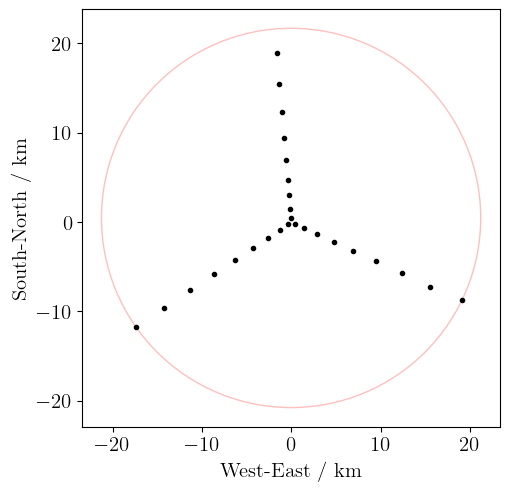

In [80]:
fig, ax = plt.subplots(layout='constrained')

dish_circle = plt.Circle((antenna_nearest_zero[0]/1000, antenna_nearest_zero[1]/1000), farthest_antenna/1000, facecolor="white", edgecolor='r', alpha=0.25)
ax.plot(enu_coords[0]/1000, enu_coords[1]/1000, '.k')
ax.add_patch(dish_circle)
ax.set(
        aspect=1,
        xlabel='West-East / km',
        ylabel='South-North / km'
)

#ax.legend(["Antennas", "Dish of {0:0.1f} km".format(max_baseline/1000)], loc="upper right", bbox_to_anchor=(2., 1.03), fancybox=True)
#ax.set_aspect('equal')

In [68]:
# We convert coordinates from ENU to ALT-AZ
azimuth, elevation = enu_to_local_altaz(b_enu, abs_b)

In [69]:
# We get the latitude of the COA in radians
latitude = telescope_center.to_geodetic().lat.to(u.rad).value

In [70]:
# We convert baselines coordinates from ALT-AZ to Equatorial
x_equatorial = np.cos(latitude) * np.sin(elevation) - np.sin(latitude) * np.cos(elevation) * np.cos(azimuth)
y_equatorial = np.cos(elevation) * np.sin(azimuth)
z_equatorial = np.sin(latitude) * np.sin(elevation) + np.cos(latitude) * np.cos(elevation) * np.cos(azimuth)

In [71]:
xyz_equatorial =  abs_b * np.vstack([x_equatorial, y_equatorial, z_equatorial])

In [72]:
# We set the observed Hour Angle and the declination
HA = np.arange(-1, 1, 0.1) * np.pi / 12.
dec = np.radians(45)

In [73]:
# We calculate the rotation matrix
R_matrix = calc_R(HA, dec)

In [74]:
# Rotation matrix has shape of (3,3, HA) and XYZ has shape of (3, nBaselines)
# Therefore to implement matrix multiplication (row * col) we need to broadcast and multiply and then sum the colums (axis=1)
uvw_meters = np.sum(R_matrix[...,np.newaxis] * xyz_equatorial[np.newaxis,:,np.newaxis,:], axis=1)

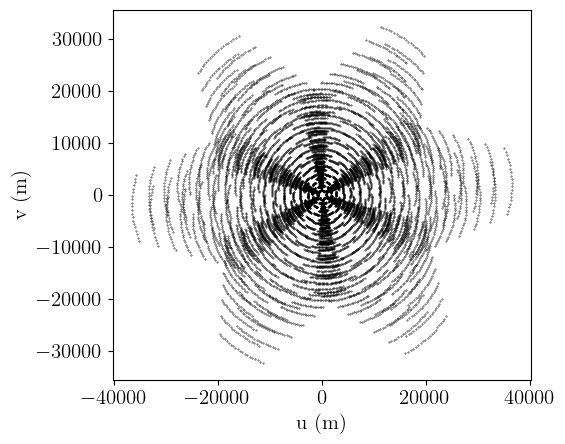

In [75]:
fig, ax = plt.subplots()
ax.scatter(uvw_meters[0],uvw_meters[1], c="black", marker=".", s=0.4)
ax.set_xlabel('u (m)') 
ax.set_ylabel('v (m)')
ax.set_aspect('equal')

In [76]:
#import matplotlib.animation
#import matplotlib.pyplot as plt
#import numpy as np
#plt.rcParams["animation.html"] = "jshtml"
#plt.rcParams['figure.dpi'] = 150  
#plt.ioff()
#fig, ax = plt.subplots()

#x = np.arange(0, len(HA))
#def animate(t):
#    plt.cla()
#    plt.scatter(uvw_meters[0, 0:t, :], uvw_meters[1, 0:t, :], c="black", marker=".")

#matplotlib.animation.FuncAnimation(fig, animate, frames=len(HA))


In [77]:
# We can also set a linearly spaced frequency range in order to increase the uv-coverage
freq_range = np.arange(1e9, 2e9, 25e6)
lambda_meters = c.value / freq_range

In [78]:
# We use broadcasting in order to divide uvw coordinates in meters by an array of wavelengths
uvw_lambdas = uvw_meters[:,:, np.newaxis, :] / lambda_meters[np.newaxis, np.newaxis, :, np.newaxis]

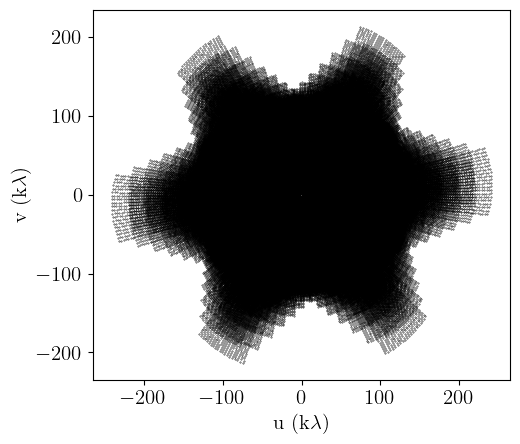

In [79]:
fig, ax = plt.subplots()
ax.scatter(uvw_lambdas[0]/1e3,uvw_lambdas[1]/1e3, c="black", marker=".", s=0.4)
ax.set_xlabel(r'u (k$\lambda$)') 
ax.set_ylabel(r'v (k$\lambda$)')
ax.set_aspect('equal')